# ANALYSIS OF METFORMIN CONTROL

This notebook contains an analysis of the effect of metformin on various tissues and organs as published in 


<img src="images/metformin-model-fits.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

In [2]:
import controlSBML as ctl

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
ctl.__version__

'1.0.11'

# Problem Statement

Metformin has proven effective at address type 2 diabetes. As such, there may be benefits if it is possible to maintain a constant dosage in physiological targets such as muscle. This is an exploratory study to investigate if the control of metformin in the blood (venus plasma) is sufficient to control metformin in muscle. This study considers a closed loop system in which: (a) metformin concentration is measured in muscle and (b) a controller can add metformin to the blood if its muscle concentration is low. We assume that there is no capability for removing metformin from the blood other than by physiological processes (e.g., intestinal absorption).

## Metformin Model

In [4]:
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
ctlsb = ctl.ControlSBML(url, input_names=["mPlasmaVenous"], output_names=["mMuscle"])
#print(ctlsb.antimony)
METFORMIN_BUILDER = ctlsb.makeSISOTransferFunctionBuilder(is_fixed_input_species=False)

// Created by libAntimony v2.13.2
function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function Glomerular(S, Flow)
  S*Flow;
end

Glomerular is "Glomerular"

function Flow(Q, S)
  Q*S;
end

Flow is "Flow"

function Flow_from_organ(Q, S, Ktp)
  Q*S/Ktp;
end

Flow_from_organ is "Flow from organ"


model *Zake2021___PBPK_model_of_metformin_in_mice__single_dose_intavenous()

  // Compartments and Species:
  compartment IntestineLumen, Liver, KidneyPlasma, Remainder, PlasmaVenous;
  compartment Urine, Feces, Heart, Muscle, Brain, Adipose, PlasmaArterial;
  compartment Lung, PortalVein, Stomach, IntestineEnterocytes, KidneyTissue;
  compartment IntestineVascular, StomachLumen, KidneyTubular;
  substanceOnly species mLiver in Liver, mKidneyPlasma in KidneyPlasma, mRemainder in Remainder;
  substanceOnly species mPlasmaVenous in PlasmaVenous, mHeart in Heart, mMuscl

In [ ]:
ctlsb.roadrunner.simulate()
ctlsb.roadrunner.plot()

# System Identification

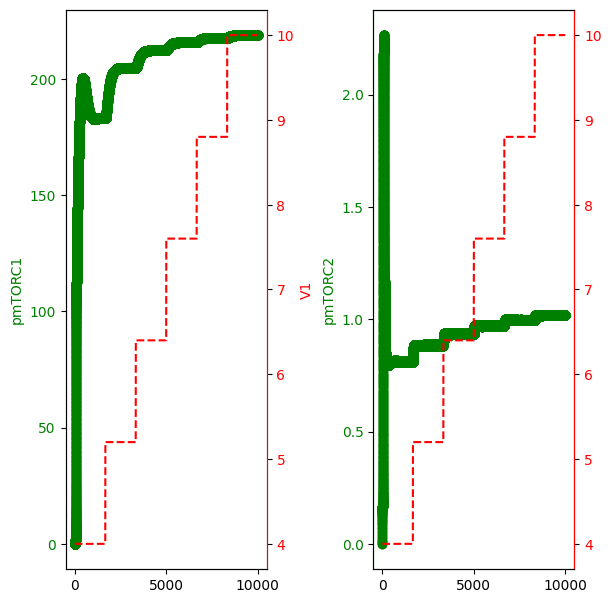

Outputs,pmTORC1,pmTORC2
Inputs,,
V1,,


In [8]:
METFORMIN_STAIRCASE = ctl.Staircase(initial_value=0, final_value=4000, num_step=5)
response_ts = METFORMIN_BUILDER.makeStaircaseResponse(staircase=METFORMIN_STAIRCASE, end_time=50)
METFORMIN_BUILDER.plotStaircaseResponse(response_ts)

* The system is controllable in the region V1 $>4$, although the control decreases with larger V1 for both complexes.
* The operating region for V1 implies an operating region for pmTORC1 of 180 to 220 and for pmTORC2 0.7 to 1.0.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Possible numerical instability: max abs residual is 30.690873



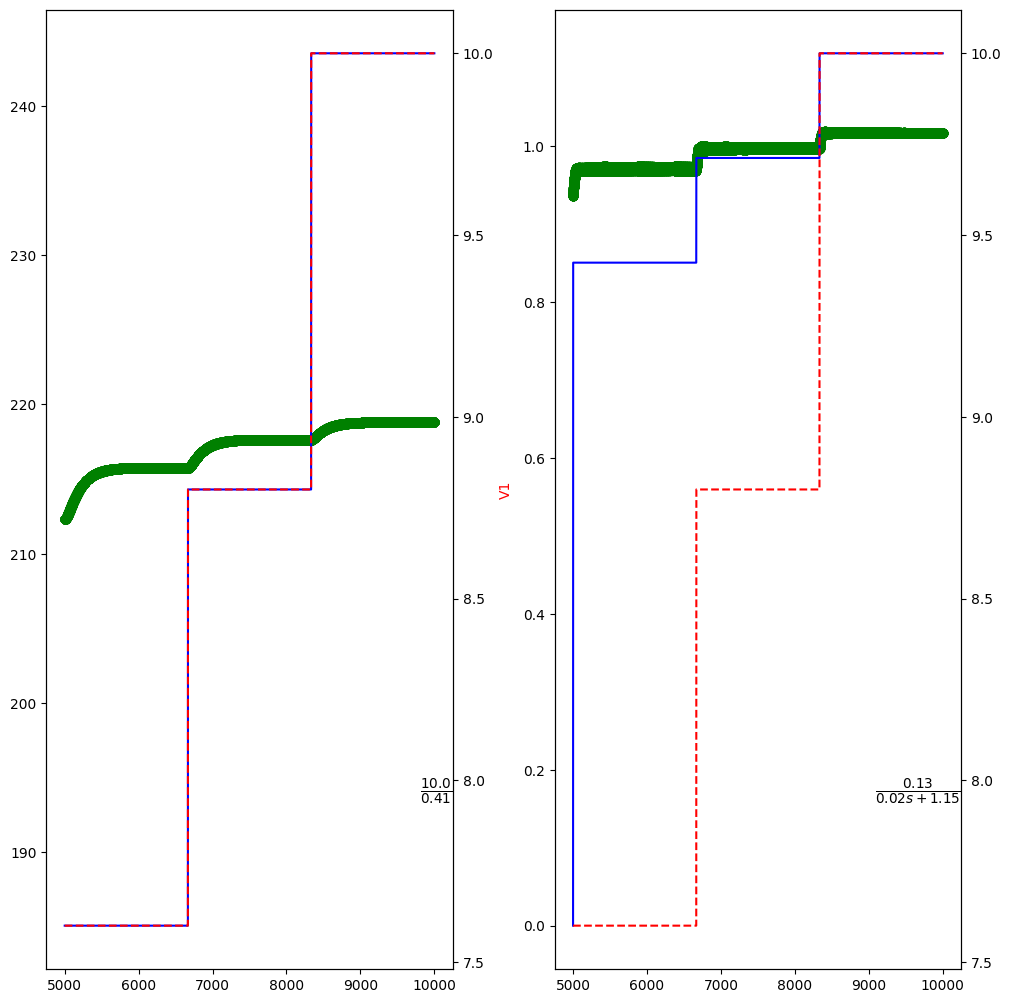

Outputs,pmTORC1,pmTORC2
Inputs,,
V1,,


In [52]:
fitter_result = METFORMIN_BUILDER.fitTransferFunction(num_numerator=2, num_denominator=3, 
                                                      staircase=METFORMIN_STAIRCASE, fit_start_time=10, start_time=0, end_time=50)
METFORMIN_BUILDER.plotFitTransferFunction(fitter_result)

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [41]:
siso = ctl.SISOClosedLoopSystem(METFORMIN_CTLSB)
siso.makePIDClosedLoopSystem(kp=2, ki=0.5)

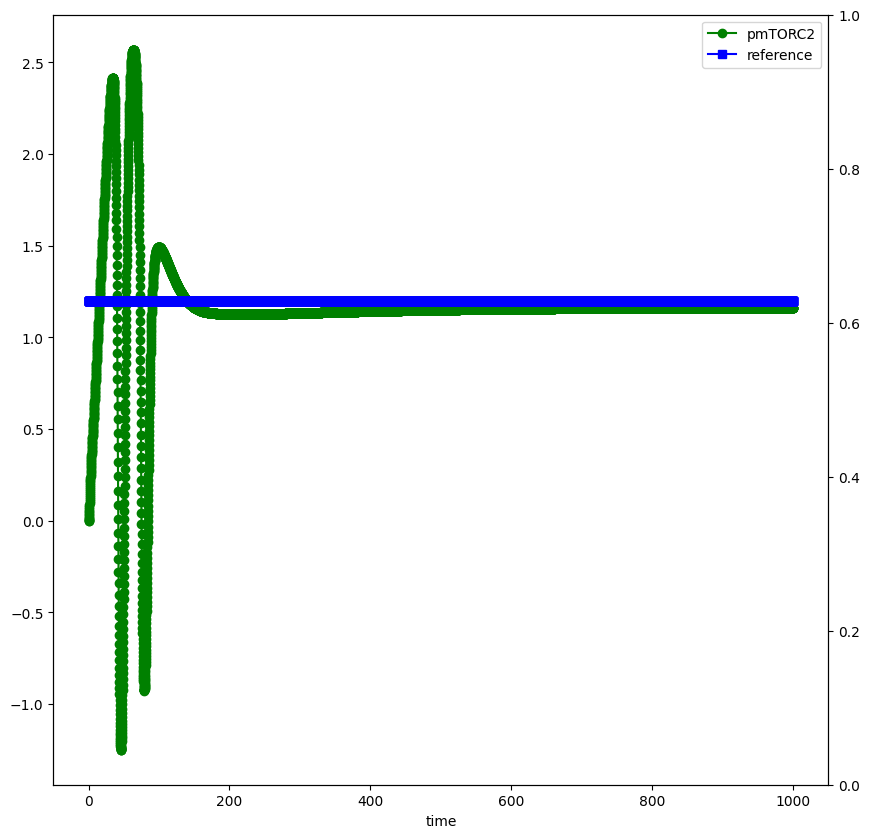

In [43]:
result_ts = siso.makeStepResponse(start_time=0, end_time=1000, step_size=1)
ctl.plotOneTS(result_ts)